# Vehicle Detection
---

## Helper Functions

In [60]:
import cv2
import glob
import time
import pickle
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

def load_image(fname):
    return mpimg.imread(fname)

def plot_images(imgs, titles, figsize=(20, 10), show_axis=True, fname=None, vis=True):
    n = len(imgs)
    if n == 1:
        f, ax = plt.subplots(figsize=figsize)
        ax.imshow(imgs[0], cmap='gray')
        ax.set_title(titles[0], fontsize=20)
        if show_axis is False:
            ax.axis('off')
    else:
        f, axs = plt.subplots(1, n, figsize=figsize)
        for i in range(n):
            axs[i].imshow(imgs[i], cmap='gray')
            axs[i].set_title(titles[i], fontsize=20)
            if show_axis is False:
                axs[i].axis('off')

    if fname is not None: 
        f.savefig('./output_images/' + fname)

    if vis is True:
        plt.show()

    f.tight_layout()
    plt.close()
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    if color == 'random':
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
    
    img_copy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], color, thick)
    return img_copy

def color_hist(img, nbins=32, bins_range=(0, 256)):
    c1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
    return hist_features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True, visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True, visualise=vis, 
                       feature_vector=feature_vec)
        return features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for fname in imgs:
        file_features = []
        # get image
        image = load_image(fname)
        
        # apply color conversion
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        
        # spatial features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
        # histogram features
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
            
        # hog features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(
                    get_hog_features(feature_image[:, :, channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    return features
    

## Load and explore data

In [2]:
import glob

cars_path = './data/vehicles/'
not_cars_path = './data/non-vehicles/'

cars = []
notcars = []

for fname in glob.glob(cars_path + '**/*.png', recursive=True):
    cars.append(fname)
    
for fname in glob.glob(not_cars_path + '**/*.png', recursive=True):
    notcars.append(fname)

print('cars:     ', len(cars))
print('not_cars: ', len(notcars))

cars:      8792
not_cars:  8968


### Print image of vehicle and non vehicle

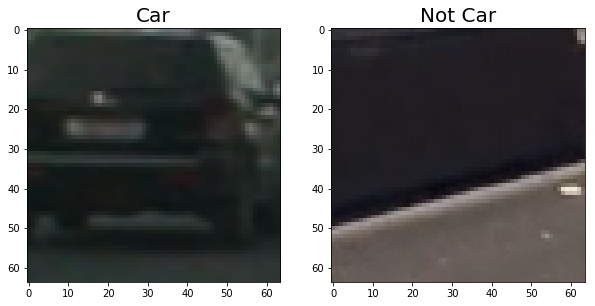

In [3]:
from random import randrange

idx = randrange(min(len(cars),len(notcars)))
car_img = load_image(cars[idx])
notcar_img = load_image(notcars[idx])

plot_images([car_img, notcar_img], 
            ['Car', 'Not Car'], 
            figsize=(10,5), 
            fname='example_images.jpg')

## Train Classifier
---
### Load image features and labels

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 9    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, 
                                hog_feat=hog_feat)

notcar_features = extract_features(notcars, 
                                   color_space=color_space, 
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, 
                                   hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('done')

### Split data and train classifier

In [11]:
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()

t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

pickle.dump(svc, open('./fitted_clf.p', 'wb'))

3.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


## Sliding Window
---
### Implement sliding window to find cars

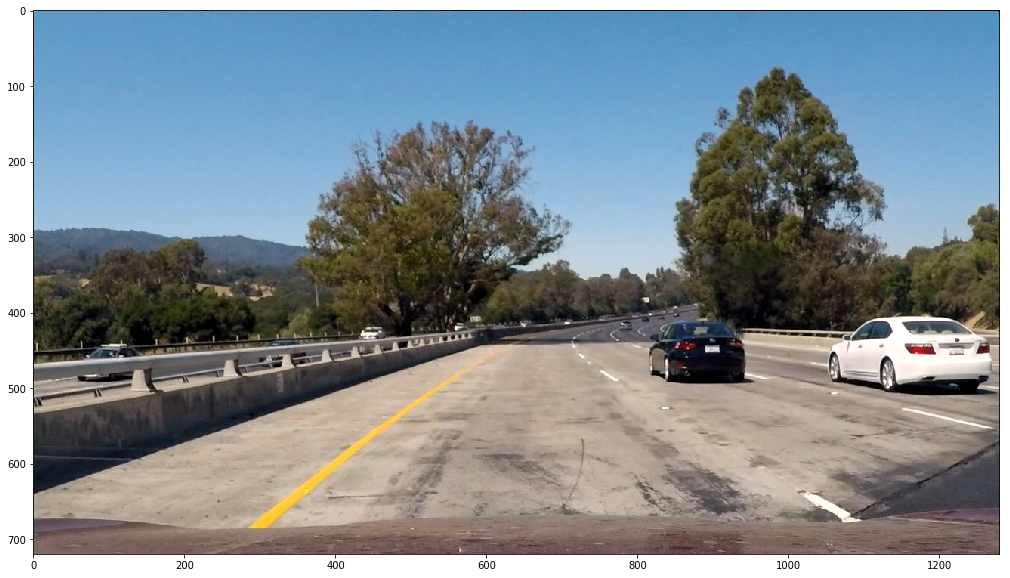

In [81]:
def find_cars(img, ystart, ystop, svc=None, X_scalar=None, scale=1.0, orient=9, 
              pix_per_cell=8, cell_per_block=2, color_space='RGB', spatial_size=(32, 32), 
              hist_bins=32, hog_channel='ALL', color=(255,0,0)):
    draw_img = np.copy(img)
    
    img_shape = (img.shape[1], img.shape[0])
    return draw_boxes(draw_img, [[(0,ystart),(img_shape[0],ystop)]], color)

img = load_image('./test_images/test1.jpg')
img_shape = (img.shape[1], img.shape[0])
    
plot_images([img],[''])